<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2022-07-01 09:15:29--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: 'loan_train.csv'

     0K .......... .......... ..                              100% 3.35M=0.007s

2022-07-01 09:15:30 (3.35 MB/s) - 'loan_train.csv' saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
!pip install seaborn 

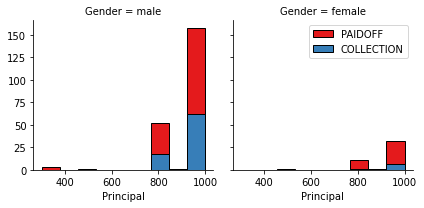

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

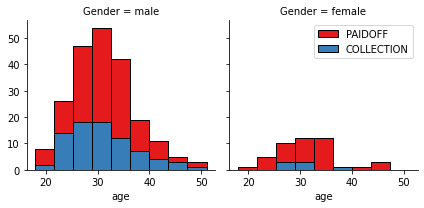

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


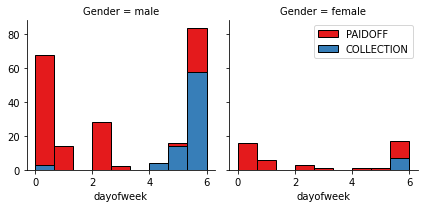

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay their loan


Let's convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

Max f1 score: 0.7499571109967403 with 4 neighbours
Max Jaccaard score: 0.7402597402597403 with 4 neighbours


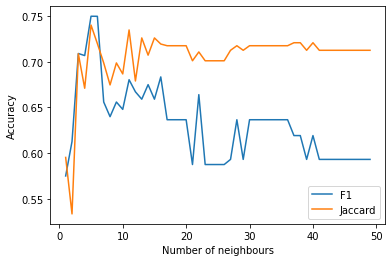

In [85]:
K = 50
f1_scores = np.zeros((K - 1))
jaccard_scores = np.zeros((K - 1))

for k in range(1, K):
     
    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
    yhat = neigh.predict(X_test)
    f1_scores[k-1] = f1_score(y_test, yhat, average = "weighted")
    jaccard_scores[k-1] = jaccard_score(y_test, yhat,pos_label="PAIDOFF")

plt.plot(range(1,K), f1_scores, label = "F1")
plt.plot(range(1, K), jaccard_scores, label = "Jaccard")
plt.xlabel("Number of neighbours")
plt.ylabel("Accuracy")
plt.legend()

print("Max f1 score:", max(f1_scores), "with", np.argmax(f1_scores), "neighbours")
print("Max Jaccaard score:", max(jaccard_scores), "with", np.argmax(jaccard_scores), "neighbours")

Both F1 and Jaccard scores are maximised with 4 neighbours. 

Now, train final model on full training set and calculate scores:

In [80]:
finalKNN = KNeighborsClassifier(n_neighbors = 4).fit(X, y)
finalKNN_yhat = finalKNN.predict(X)
print("F1 score on full training set:", f1_score(y, finalKNN_yhat, average = "weighted"))
print("Jaccard score on full training set:", jaccard_score(y, finalKNN_yhat,pos_label="PAIDOFF"))

F1 score on full training set: 0.8176942838792549
Jaccard score on full training set: 0.7777777777777778


# Decision Tree


In [23]:
from sklearn.tree import DecisionTreeClassifier

Maximum f1 score: 0.6155936018004984 with the entropy criterion
Maximum jaccard score: 0.6049382716049383 with the entropy criterion


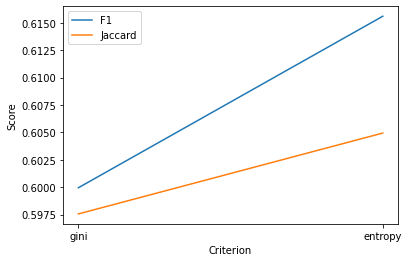

In [105]:
criterions = ["gini", "entropy"]
f1_scores = np.zeros(len(criterions))
jaccard_scores = np.zeros(len(criterions))

for i, c in enumerate(criterions):
    drugTree = DecisionTreeClassifier(criterion=c)
    drugTree.fit(X_train, y_train)
    predTree = drugTree.predict(X_test)
    f1_scores[i] = f1_score(y_test, predTree, average="weighted")
    jaccard_scores[i] = jaccard_score(y_test, predTree, pos_label = "PAIDOFF")
    
plt.plot(criterions, f1_scores, label = "F1")
plt.plot(criterions, jaccard_scores, label = "Jaccard")
plt.xlabel("Criterion")
plt.ylabel("Score")
plt.legend()

print("Maximum f1 score:", max(f1_scores), "with the", criterions[np.argmax(f1_scores)], "criterion")
print("Maximum jaccard score:", max(jaccard_scores), "with the", criterions[np.argmax(jaccard_scores)], "criterion")

Entropy gave the best scores so go with entropy criterion. 

Maximum f1 score: 0.6307879651905314 with the sqrt max_features
Maximum jaccard score: 0.6125 with the sqrt max_features


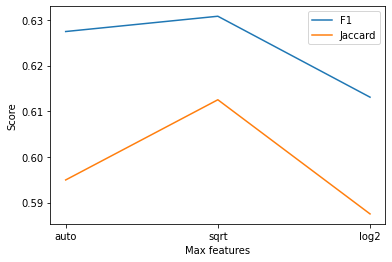

In [111]:
max_features = ["auto", "sqrt", "log2"]
f1_scores = np.zeros(len(max_features))
jaccard_scores = np.zeros(len(max_features))

for i, mf in enumerate(max_features):
    drugTree = DecisionTreeClassifier(criterion="entropy", max_features = mf)
    drugTree.fit(X_train, y_train)
    predTree = drugTree.predict(X_test)
    f1_scores[i] = f1_score(y_test, predTree, average="weighted")
    jaccard_scores[i] = jaccard_score(y_test, predTree, pos_label = "PAIDOFF")
    
plt.plot(max_features, f1_scores, label = "F1")
plt.plot(max_features, jaccard_scores, label = "Jaccard")
plt.xlabel("Max features")
plt.ylabel("Score")
plt.legend()

print("Maximum f1 score:", max(f1_scores), "with the", max_features[np.argmax(f1_scores)], "max_features")
print("Maximum jaccard score:", max(jaccard_scores), "with the", max_features[np.argmax(jaccard_scores)], "max_features")

Best scores given by sqrt max_features so go with that.

Max f1 score: 0.6932463881111859 with max depth =  7
Max jaccard score: 0.7160493827160493 with max depth =  7


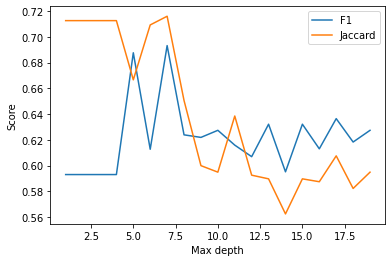

In [120]:
max_depth = range(1, 20)

f1_scores = np.zeros(len(max_depth))
jaccard_scores = np.zeros(len(max_depth))

for md in max_depth:
    
    drugTree = DecisionTreeClassifier(criterion = "entropy", max_depth = md, max_features = "sqrt") 
    drugTree.fit(X_train, y_train)
    predTree = drugTree.predict(X_test)
    f1_scores[md-1] = f1_score(y_test, predTree, average="weighted")
    jaccard_scores[md-1] = jaccard_score(y_test, predTree, pos_label="PAIDOFF")

plt.plot(max_depth, f1_scores, label = "F1")
plt.plot(max_depth, jaccard_scores, label ="Jaccard")
plt.xlabel("Max depth")
plt.ylabel("Score")
plt.legend()

print("Max f1 score:", max(f1_scores), "with max depth = ", np.argmax(f1_scores) + 1)
print("Max jaccard score:", max(jaccard_scores), "with max depth = ", np.argmax(jaccard_scores) + 1)


Best scores given with max depth = 7.

Now build and train final model on full training set:

In [121]:
final_drugTree = DecisionTreeClassifier(criterion = "entropy", max_depth = 7, max_features = "sqrt") 
final_drugTree.fit(X, y)
final_predTree = final_drugTree.predict(X)
print("F1 score on full training set:", f1_score(y, final_predTree, average="weighted"))
print("Jaccard score on full training set:", jaccard_score(y, final_predTree, pos_label="PAIDOFF"))

F1 score on full training set: 0.730144301004202
Jaccard score on full training set: 0.7689969604863222


# Support Vector Machine


In [29]:
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import itertools

Max f1 score: 0.593072591221168 with kernel: rbf
Max jaccard score: 0.7126436781609196 with kernel: rbf


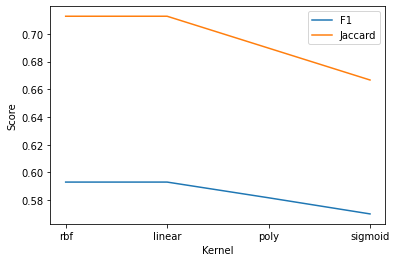

In [123]:
kernels = ["rbf", "linear", "poly", "sigmoid"]
f1_scores = np.zeros(len(kernels))
jaccard_scores = np.zeros(len(kernels))

for i, k in enumerate(kernels):
    clf = svm.SVC(kernel=k)
    clf.fit(X_train, y_train) 
    yhat = clf.predict(X_test)
    f1_scores[i] = f1_score(y_test, yhat, average='weighted')
    jaccard_scores[i] = jaccard_score(y_test, yhat,pos_label = "PAIDOFF")
    
plt.plot(kernels, f1_scores, label = "F1")
plt.plot(kernels, jaccard_scores, label ="Jaccard")
plt.xlabel("Kernel")
plt.ylabel("Score")
plt.legend()

print("Max f1 score:", max(f1_scores), "with kernel:", kernels[np.argmax(f1_scores)])
print("Max jaccard score:", max(jaccard_scores), "with kernel:", kernels[np.argmax(jaccard_scores)])


Best scores with rbf kernel

Maximum f1 score: 0.593072591221168 with c = 0.01
Maximum jaccard score: 0.7126436781609196 with c = 0.01


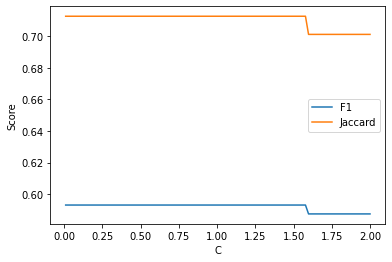

In [130]:
C = np.linspace(0.01, 2, 100)
f1_scores = np.zeros(len(C))
jaccard_scores = np.zeros(len(C))

for i, c in enumerate(C):
    clf = svm.SVC(kernel='rbf', C = c)
    clf.fit(X_train, y_train) 
    yhat = clf.predict(X_test)
    f1_scores[i] = f1_score(y_test, yhat, average='weighted')
    jaccard_scores[i] = jaccard_score(y_test, yhat,pos_label = "PAIDOFF")

plt.plot(C, f1_scores, label = "F1")
plt.plot(C, jaccard_scores, label ="Jaccard")
plt.xlabel("C")
plt.ylabel("Score")
plt.legend()

print("Maximum f1 score:", max(f1_scores), "with c =", C[np.argmax(f1_scores)])
print("Maximum jaccard score:", max(jaccard_scores), "with c =", C[np.argmax(jaccard_scores)])

Best scores with 0.01 <= C <=1.5 so go with default of 1

Now train final model on full training set

In [131]:
final_clf = svm.SVC(kernel='rbf', C = 1)
final_clf.fit(X, y) 
final_clf_yhat = final_clf.predict(X)
print("F1 score on full training set:", f1_score(y, final_clf_yhat, average='weighted'))
print("Jaccard score on full training set:", jaccard_score(y, final_clf_yhat,pos_label = "PAIDOFF"))

F1 score on full training set: 0.6647688577527595
Jaccard score on full training set: 0.7580174927113703


# Logistic Regression


In [150]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss

Documentation says liblinear solver is best for small dataset so go with that

Maximum f1 score: 0.593072591221168 with the l2 penalty
Maximum jaccard score: 0.7126436781609196 with the l2 penalty
Maximum f1 score: 0.593072591221168 with the l2 penalty
Maximum log loss score: 0.6931471805599455 with the l1 penalty


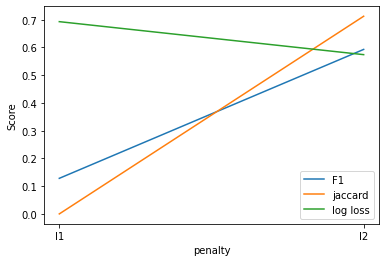

In [154]:
penalties = ['l1', 'l2']
f1_scores = np.zeros(len(penalties))
jaccard_scores = np.zeros(len(penalties))
logloss_scores = np.zeros(len(penalties))

for i, penalty in enumerate(penalties):
    LR = LogisticRegression(C=0.01, solver="liblinear", penalty = penalty).fit(X_train,y_train)
    yhat = LR.predict(X_test)
    yhat_prob = LR.predict_proba(X_test)
    f1_scores[i] = f1_score(y_test, yhat, average='weighted')
    jaccard_scores[i] = jaccard_score(y_test, yhat,pos_label = "PAIDOFF")
    logloss_scores[i] = log_loss(y_test, yhat_prob)
    
plt.plot(penalties, f1_scores, label="F1")
plt.plot(penalties, jaccard_scores, label="jaccard")
plt.plot(penalties, logloss_scores, label="log loss")
plt.xlabel("penalty")
plt.ylabel("Score")
plt.legend()

print("Maximum f1 score:", max(f1_scores), "with the", penalties[np.argmax(f1_scores)], "penalty")
print("Maximum jaccard score:", max(jaccard_scores), "with the", penalties[np.argmax(jaccard_scores)], "penalty")
print("Maximum f1 score:", max(f1_scores), "with the", penalties[np.argmax(f1_scores)], "penalty")
print("Maximum log loss score:", max(logloss_scores), "with the", penalties[np.argmax(logloss_scores)], "penalty")

Best score with l2 penalty for all scores, as lower logloss indicates better predictions

Maximum f1 score: 0.593072591221168 with c = 0.01
Maximum jaccard score: 0.7126436781609196 with c = 0.01
Maximum log loss score: 0.5742007723702486 with c= 0.01


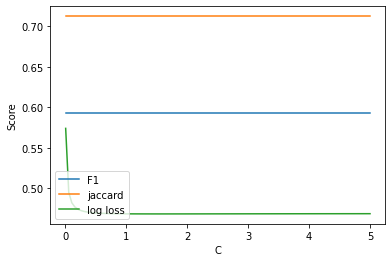

In [159]:
C = np.linspace(0.01, 5, 100)
f1_scores = np.zeros(len(C))
jaccard_scores = np.zeros(len(C))
logloss_scores = np.zeros(len(C))

for i, c in enumerate(C):
    LR = LogisticRegression(C=c, solver="liblinear", penalty = "l2").fit(X_train,y_train)
    yhat = LR.predict(X_test)
    yhat_prob = LR.predict_proba(X_test)
    f1_scores[i] = f1_score(y_test, yhat, average='weighted')
    jaccard_scores[i] = jaccard_score(y_test, yhat,pos_label = "PAIDOFF")
    logloss_scores[i] = log_loss(y_test, yhat_prob)
    
plt.plot(C, f1_scores, label="F1")
plt.plot(C, jaccard_scores, label="jaccard")
plt.plot(C, logloss_scores, label="log loss")
plt.xlabel("C")
plt.ylabel("Score")
plt.legend()

print("Maximum f1 score:", max(f1_scores), "with c =", C[np.argmax(f1_scores)])
print("Maximum jaccard score:", max(jaccard_scores), "with c =", C[np.argmax(jaccard_scores)])
print("Maximum log loss score:", max(logloss_scores), "with c=", C[np.argmax(logloss_scores)])

Worst values according to logloss is very small values of c, after that c doesn't seem to make a difference so go with default c=1

Now train final model on full training set

In [162]:
final_LR = LogisticRegression(C=1, solver="liblinear", penalty = "l2").fit(X,y)
final_LR_yhat = final_LR.predict(X)
final_LR_yhat_prob = final_LR.predict_proba(X)
print("F1 score on full training set:", f1_score(y, final_LR_yhat, average='weighted'))
print("Jaccard score on full training set:", jaccard_score(y, final_LR_yhat, pos_label = "PAIDOFF"))
print("Logloss score on full training set:", log_loss(y, final_LR_yhat_prob))

F1 score on full training set: 0.6997291283105058
Jaccard score on full training set: 0.7447447447447447
Logloss score on full training set: 0.433946460100774


# Model Evaluation using Test set


In [163]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [164]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-07-01 10:34:25--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: 'loan_test.csv'

     0K ...                                                   100% 3.77G=0s

2022-07-01 10:34:26 (3.77 GB/s) - 'loan_test.csv' saved [3642/3642]



### Load Test set for evaluation


In [201]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [202]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)

test_X = test_Feature
test_y = test_df['loan_status'].values
test_X= preprocessing.StandardScaler().fit(test_X).transform(test_X)

In [204]:
finalKNN = KNeighborsClassifier(n_neighbors = 4).fit(test_X, test_y)
finalKNN_yhat = finalKNN.predict(test_X)
print("F1 score on full test set:", f1_score(test_y, finalKNN_yhat, average = "weighted"))
print("Jaccard score on full test set:", jaccard_score(test_y, finalKNN_yhat,pos_label="PAIDOFF"))

F1 score on full test set: 0.8518518518518519
Jaccard score on full test set: 0.8181818181818182


In [205]:
final_drugTree = DecisionTreeClassifier(criterion = "entropy", max_depth = 7, max_features = "sqrt") 
final_drugTree.fit(test_X, test_y)
final_predTree = final_drugTree.predict(test_X)
print("F1 score on full training set:", f1_score(test_y, final_predTree, average="weighted"))
print("Jaccard score on full training set:", jaccard_score(test_y, final_predTree, pos_label="PAIDOFF"))

F1 score on full training set: 0.943758573388203
Jaccard score on full training set: 0.9285714285714286


In [206]:
final_clf = svm.SVC(kernel='rbf', C = 1)
final_clf.fit(test_X, test_y) 
final_clf_yhat = final_clf.predict(test_X)
print("F1 score on full training set:", f1_score(test_y, final_clf_yhat, average='weighted'))
print("Jaccard score on full training set:", jaccard_score(test_y, final_clf_yhat,pos_label = "PAIDOFF"))

F1 score on full training set: 0.8539804171988081
Jaccard score on full training set: 0.851063829787234


In [207]:
final_LR = LogisticRegression(C=1, solver="liblinear", penalty = "l2").fit(test_X,test_y)
final_LR_yhat = final_LR.predict(test_X)
final_LR_yhat_prob = final_LR.predict_proba(test_X)
print("F1 score on full training set:", f1_score(test_y, final_LR_yhat, average='weighted'))
print("Jaccard score on full training set:", jaccard_score(test_y, final_LR_yhat, pos_label = "PAIDOFF"))
print("Logloss score on full training set:", log_loss(test_y, final_LR_yhat_prob))

F1 score on full training set: 0.7719407963310403
Jaccard score on full training set: 0.7446808510638298
Logloss score on full training set: 0.4017613480349212


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 82%     | 85%      | NA      |
| Decision Tree      | 93%     | 94%      | NA      |
| SVM                | 85%     | 85%      | NA      |
| LogisticRegression | 74%     | 77%      | 40%     |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
